<a href="https://colab.research.google.com/github/preritt/KProj/blob/master/Contd%20train%20Capacity_check_Improved_accuracy_to_89p5Test_Valid_91p1_HybridModel_04242019_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load standard libraries

In [1]:
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from keras.datasets import cifar10
from sklearn import preprocessing
from keras import losses
from keras.models import model_from_json
import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


In [0]:
from keras.utils.vis_utils import plot_model


In [0]:
keras.backend.clear_session()

## Load image data

170500096/170498071 [==============================] - 49s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  # Remove the CWD from sys.path while we load stuff.


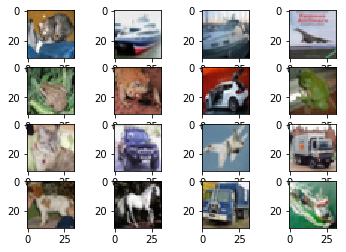

In [4]:
from matplotlib import pyplot
from scipy.misc import toimage
from keras.datasets import cifar10
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,4):
        for j in range(0,4):
            pyplot.subplot2grid((4,4),(i,j))
            pyplot.imshow(toimage(X[k]))
            k = k+1
    # show the plot
    pyplot.show()
 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
show_imgs(x_test[:16])


## Create Function to get data corresponding to three labels

In [0]:
# This function takes the entire traaining data and test data and corresponding categorical label and returns the corresponding data in class indices
def getThreeClassesTrainTest(class_indices,train_data,train_labels,test_data,test_labels):
  all_train_data = []
  all_train_data_label = []
  all_test_data = []
  all_test_data_label = []
  for ind in class_indices:
    this_class_location_train =  np.where(train_labels==ind)[0] # train_labels[train_labels == ind]
    this_class_data_train = train_data[this_class_location_train,:]
    this_class_data_train_label = train_labels[this_class_location_train]
#     print(this_class_location_train)
    
    this_class_location_test = np.where(test_labels==ind)[0] #test_labels[test_labels == ind]
    this_class_data_test = test_data[this_class_location_test,:]
    this_class_data_test_label = test_labels[this_class_location_test]
    
    all_train_data.append(this_class_data_train)
    all_test_data.append(this_class_data_test)
    all_train_data_label.append(this_class_data_train_label)
    all_test_data_label.append(this_class_data_test_label)
    
  train_data_three = all_train_data[0]
  train_label_three = all_train_data_label[0]
  test_data_three = all_test_data[0]
  test_label_three = all_test_data_label[0]
  
  for j in range(1,len(class_indices)):
    train_data_three = np.concatenate((train_data_three,all_train_data[j]))
    train_label_three = np.concatenate((train_label_three,all_train_data_label[j]))

    test_data_three = np.concatenate((test_data_three,all_test_data[j]))
    test_label_three = np.concatenate((test_label_three,all_test_data_label[j]))
#   print(train_label_three.shape)
  train_label_three = np.reshape(train_label_three,newshape=(-1,))
  test_label_three = np.reshape(test_label_three,newshape=(-1,))
  return train_data_three, train_label_three, test_data_three,test_label_three

## Get data for three classes using getThreeClassesTrainTest function

In [0]:
train_three_data,train_three_label,test_three_data,test_three_label = getThreeClassesTrainTest([ 0,3,5 ],x_train,y_train,x_test,y_test)

(array([5000.,    0.,    0.,    0.,    0.,    0., 5000.,    0.,    0.,
        5000.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

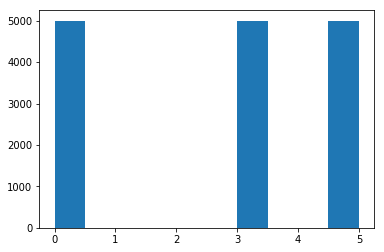

In [7]:
plt.hist(train_three_label)

(array([1000.,    0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,
        1000.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

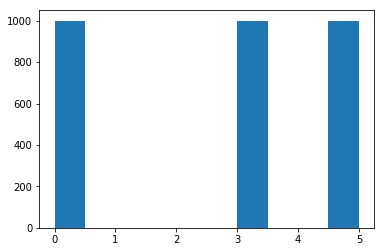

In [8]:
plt.hist(test_three_label)

In [0]:
train_three_data, train_three_label = shuffle(train_three_data, train_three_label )
test_three_data,test_three_label = shuffle(test_three_data,test_three_label )

In [0]:
le = preprocessing.LabelEncoder()
le.fit_transform(train_three_label)
train_three_label_cat = le.transform(train_three_label)
test_three_label_cat = le.transform(test_three_label)
train_three_label_one_hot = to_categorical(train_three_label_cat)
test_three_label_one_hot = to_categorical(test_three_label_cat)

In [0]:
# split train data and to create validation data
train_X,valid_X,train_ground,valid_ground = train_test_split(train_three_data,
                                                             train_three_label_one_hot,
                                                             test_size=0.2,
                                                             random_state=13)

In [0]:
num_classes = test_three_label_one_hot.shape[1]

## Define the model

In [0]:
x, y = 32, 32
inChannel = 3
input_img = Input(shape = (x, y, inChannel))
ep = 10 
weight_decay = 1e-4

In [0]:
def cifar10Classifier(input_img):
  
  conv1 = (Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:], activation='elu'))(input_img)
  conv1 = BatchNormalization()(conv1)
  conv1 = (Conv2D(32, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv1)
  conv1 = BatchNormalization()(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
  drop1= Dropout(.2)(pool1)

  conv2 = (Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='elu'))(drop1)
  conv2 = BatchNormalization()(conv2)
  conv2 = (Conv2D(64, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv2)
  conv2 = BatchNormalization()(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #14 x 14 x 32
  drop2= Dropout(.3)(pool2)

  conv3 = (Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='elu'))(drop2)
  conv3 = BatchNormalization()(conv3)
  conv3 = (Conv2D(128, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv3)
  conv3 = BatchNormalization()(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #14 x 14 x 32
  drop3= Dropout(.4)(pool3)

  flat = Flatten()(drop3)
  out = Dense(num_classes, activation='softmax')(flat)
  
  return out

## Define functions for calculation of DI score
getDIScoreOfLayer(layer_output, true_labels), 
getDIScoreOfLayerCNNLayer(cnn_outputs, true_labels)


In [0]:
def getDIScoreOfLayer(layer_output, true_labels):
  # computeScatterMatrix
  rho = 1e-6
  mu = layer_output.mean(axis=0)
#   print(mu.shape)
  mu = mu.reshape((1,-1))
  centered_data = layer_output - mu
  S_bar = np.matmul(centered_data.T,centered_data)
  # compute between class matrix
  total_classes = true_labels.max()
  S_B = np.zeros(shape = (mu.shape[1],mu.shape[1]))
  S_W = np.zeros(shape = (mu.shape[1],mu.shape[1]))
  unique_classes = np.unique(true_labels)
  unique_classes_list = np.ndarray.tolist(unique_classes)
  for l in unique_classes_list:
    class_l_index = np.where(true_labels == l)
    class_l_output = layer_output[class_l_index[0],:]
    mu_l = class_l_output.mean(axis=0)
    mu_l = mu_l.reshape((1,-1))
    total_examples_this_class = class_l_index[0].shape   
    ss = mu_l - mu
    S_B = S_B + total_examples_this_class*np.matmul((mu_l - mu).T,(mu_l - mu))

  DI_Score = np.trace(np.matmul(np.linalg.inv(S_bar + rho*np.eye(S_bar.shape[0])),S_B))
  return DI_Score

In [0]:
def getDIScoreOfLayerCNNLayer(cnn_outputs, true_labels):
  # computeScatterMatrix
  number_of_filters = cnn_outputs.shape[3]
  cnn_di_scores = []
  for filt in range(0,number_of_filters):
    outputs_filter = cnn_outputs[:,:,:,filt]
    outputs_filter_reshaped = np.reshape(outputs_filter, newshape=(cnn_outputs.shape[0],-1))
    this_filter_score = getDIScoreOfLayer(outputs_filter_reshaped, true_labels)
    cnn_di_scores.append(this_filter_score)
  return cnn_di_scores

## define a function to get and plot di score of a layer. It takes inputs - trained model, layer name to get DI scores and returns a plot with some statistics

In [0]:
def createCNNLayerDIScorePlot(trained_model, layer_name, data_to_use = train_three_data , data_label =train_three_label ):
  get_cnn1_output_function = K.function([trained_model.layers[0].input],
                                  [trained_model.get_layer(layer_name).output])   #get_layer test_three_label
  cnn1_output = get_cnn1_output_function([data_to_use])[0]
  di_scores = getDIScoreOfLayerCNNLayer(cnn1_output, data_label)
  # plot DI score
  y_pos  = np.arange(len(di_scores))
  plt.bar(y_pos, di_scores, align='center', alpha=0.5)
  plt.xlabel('FilterNumber')
  plt.ylabel('DI Score')

  print('Mean of DI SCore: ',np.mean(di_scores))
  print('STD of DI Score: ', np.std(di_scores))
  print('MAX of DI Score: ', np.max(di_scores))
  plt.title('DI score - Data - D_L, Network -N_L, Conv_6')
#   plt.ylim([0,1])
  return di_scores

## load pretrained model

In [18]:
loaded_model_low_accuracy = keras.models.load_model('lowAccuracyModelData.h5')
loaded_model_high_accuracy = keras.models.load_model('highAccuracyModelData.h5')


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
loaded_model_low_accuracy.evaluate(valid_X, valid_ground, verbose=0)

[0.30999894126256305, 0.8993333333333333]

In [0]:
loaded_model_low_accuracy.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________

## Create a plot for DI score using function createCNNLayerDIScorePlot()

#### On train data

Mean of DI SCore:  0.5925391774436748
STD of DI Score:  0.05669778775839462
MAX of DI Score:  0.6699797882972818


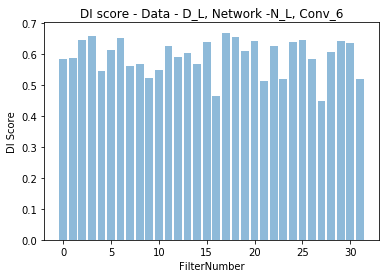

In [19]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_2'
discores_low_acc_model = createCNNLayerDIScorePlot(loaded_model_low_accuracy, layer_name)

Mean of DI SCore:  0.6055427520493157
STD of DI Score:  0.045351438440107646
MAX of DI Score:  0.7097901246332267


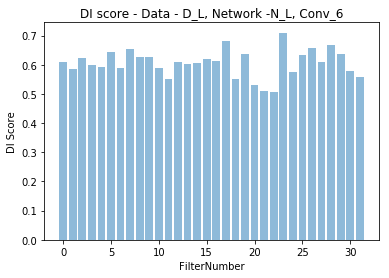

In [20]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_2'

discores_high_acc_model = createCNNLayerDIScorePlot(loaded_model_high_accuracy, layer_name)

## Pick top 10 DI scores

#### On validation data

In [0]:
valid_ground_actual = np.argmax(valid_ground, axis=1)
# valid_ground_actual.shape
# data_to_use = train_three_data , data_label =train_three_label

Mean of DI SCore:  1.0283991648798934
STD of DI Score:  0.04766352471097197
MAX of DI Score:  1.102371604561001


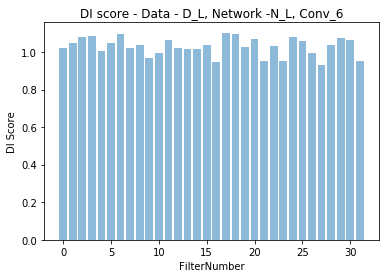

In [0]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_2'
discores_low_acc_model_valid = createCNNLayerDIScorePlot(loaded_model_low_accuracy,
                                                   layer_name, data_to_use=valid_X, data_label=valid_ground_actual)

Mean of DI SCore:  1.0489336398135918
STD of DI Score:  0.03772804064192905
MAX of DI Score:  1.1368837585485827


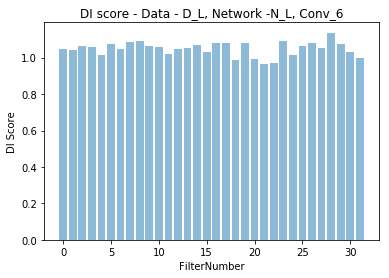

In [0]:
# now get DI score of a layer from high accuracy and low accuracy model
layer_name = 'conv2d_2'

discores_high_acc_model_valid = createCNNLayerDIScorePlot(loaded_model_high_accuracy,
                                                   layer_name, data_to_use=valid_X, data_label=valid_ground_actual)

In [0]:
np.sort(discores_high_acc_model)

array([0.50778735, 0.51148141, 0.5316608 , 0.5503721 , 0.55231392,
       0.55683133, 0.5754899 , 0.57891548, 0.58448689, 0.58936178,
       0.58980302, 0.59096041, 0.59923165, 0.60396759, 0.6067217 ,
       0.60815117, 0.60818232, 0.60875793, 0.61246232, 0.61911506,
       0.62163669, 0.62485589, 0.62771089, 0.63252923, 0.63514822,
       0.63617041, 0.64203204, 0.65381118, 0.65792124, 0.66861217,
       0.68109371, 0.70979014])

In [21]:

# (discores_high_acc_model)
K = 10 # how many channels to pick
high_acc_di_sorted = np.argsort(discores_high_acc_model)
high_acc_di_sorted_list = np.ndarray.tolist(high_acc_di_sorted)
top_channels = high_acc_di_sorted_list[-K:]
top_channels

[9, 25, 19, 29, 5, 7, 26, 28, 17, 23]

In [0]:
total_channels = len(discores_high_acc_model)
# total_channels

In [0]:
enable_training = True

In [0]:
# # returns 
# def highAccuracyModelTillConv2(input_img): 
#   conv1_1 = (Conv2D(32, (3,3), padding='same',
#                     kernel_regularizer=regularizers.l2(weight_decay), 
#                     input_shape=x_train.shape[1:], activation='elu', trainable = enable_training,
#                     name = 'HighAccuracyConv1'))(input_img)
#   conv1_2 = BatchNormalization(name = 'HighAccuracyBN1',
#                               trainable = enable_training)(conv1_1)
#   conv2_1 = (Conv2D(32, (3,3), padding='same', activation= 'elu',trainable = enable_training,
#                     name = 'HighAccuracyConv2',kernel_regularizer=regularizers.l2(weight_decay)))(conv1_2)
# #   conv2_2 = BatchNormalization(name = 'HighAccuracyBN2',
# #                               trainable = enable_training)(conv2_1)  
# #   create a mask
#   # first swap axis and make channels the 0th dimension
# #   swapped_conv2 = keras.backend.permute_dimensions(conv2_1, (3,1,2,0))
#   masked = []
#   for ch in range(0,total_channels):
#     if ch in top_channels:
#       m = False
#     else:
#       m = True 
#     masked.append(m)
#   corrected_conv2 = tf.boolean_mask(conv2_1,mask = masked, axis=3)
#   print(corrected_conv2.shape)
# #   input_shape = swapped_conv2.get_shape().as_list()
# #   print(swapped_conv2.shape)
# #   masked_swapped_conv2 = tf.boolean_mask(swapped_conv2,mask = masked)
# #   print(masked_swapped_conv2.shape)
# #   corrected_conv2 = keras.backend.permute_dimensions(masked_swapped_conv2, (3,1,2,0))
# #   print(masked) Masking(mask_value=0., input_shape=(5, 100))
# #   swapped_conv2_masked = Lambda(lambda x: keras.backend.boolean_mask(swapped_conv2, mask = 3))(out)
# #   masked_swapped_conv2 = keras.backend.manual_variable_initiali
#   return corrected_conv2

In [0]:
# returns 
def highAccuracyModelTillConv2(input_img): 
  conv1_1 = (Conv2D(32, (3,3), padding='same',
                    kernel_regularizer=regularizers.l2(weight_decay), 
                    input_shape=x_train.shape[1:], activation='elu', trainable = enable_training,
                    name = 'HighAccuracyConv1'))(input_img)
  conv1_2 = BatchNormalization(name = 'HighAccuracyBN1',
                              trainable = enable_training)(conv1_1)
  conv2_1 = (Conv2D(32, (3,3), padding='same', activation= 'elu',trainable = enable_training,
                    name = 'HighAccuracyConv2',kernel_regularizer=regularizers.l2(weight_decay)))(conv1_2)
#   conv2_2 = BatchNormalization(name = 'HighAccuracyBN2',
#                               trainable = enable_training)(conv2_1)  
  
  return conv2_1

In [0]:
from keras.layers import Dense, Concatenate, Input, Lambda


In [0]:
import tensorflow as tf
def cifar10ClassifierTransfer(input_img, conv2_high):
  
  # Add additional inputs to 
  
  conv1_1 = (Conv2D(32, (3,3), padding='same',name = 'lowAccuracyModelConv1_1',
                    trainable = enable_training, kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:], activation='elu'))(input_img)
  conv1_2 = BatchNormalization(name = 'lowAccuracyModelBN1',
                              trainable = enable_training)(conv1_1)
  conv2_1 = (Conv2D(32, (3,3), padding='same',name = 'lowAccuracyModelConv2_1',
                    trainable = enable_training, activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv1_2)
  channels = top_channels
  branch_outputs = []
#   orig_channel = conv2_1
  # create a mask here
  branch_outputs.append(conv2_1)
  for i in channels:
      # Slicing the ith channel:
      out = Lambda(lambda x: x[:,:,:, i])(conv2_high)      
      # Setting up your per-channel layers (replace with actual sub-models):
      layer_out = Lambda(lambda x: keras.backend.expand_dims(x, axis = 3))(out)
      branch_outputs.append(layer_out)
  merged = Concatenate()(branch_outputs)


  conv2_2 = BatchNormalization()(merged)
  pool2_3 = MaxPooling2D(pool_size=(2, 2))(conv2_2) #14 x 14 x 32
  drop2_4= Dropout(.2)(pool2_3)

  conv3_1 = (Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='elu'))(drop2_4)
  conv3_2 = BatchNormalization()(conv3_1)
  conv4_1 = (Conv2D(64, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv3_2)
  conv4_2 = BatchNormalization()(conv4_1)
  pool4_3 = MaxPooling2D(pool_size=(2, 2))(conv4_2) #14 x 14 x 32
  drop4_4= Dropout(.3)(pool4_3)

  conv5_1 = (Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), activation='elu'))(drop4_4)
  conv5_2 = BatchNormalization()(conv5_1)
  conv6_1 = (Conv2D(128, (3,3), padding='same', activation= 'elu',kernel_regularizer=regularizers.l2(weight_decay)))(conv5_2)
  conv6_2 = BatchNormalization()(conv6_1)
  pool6_3 = MaxPooling2D(pool_size=(2, 2))(conv6_2) #14 x 14 x 32
  drop6_4= Dropout(.4)(pool6_3)

  flat = Flatten()(drop6_4)
  out = Dense(num_classes, activation='softmax')(flat)
  
  return out

In [27]:
top_channels

[9, 25, 19, 29, 5, 7, 26, 28, 17, 23]

In [33]:
high_acc_output = highAccuracyModelTillConv2(input_img)
modelFilt = Model(input_img, 
              cifar10ClassifierTransfer(input_img,
              high_acc_output))
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(train_three_data)
 
#training
batch_size = 64
 
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
# model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

modelFilt.compile(loss=losses.categorical_crossentropy, optimizer=opt_rms, metrics=['accuracy'])

modelFilt.summary()
 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
HighAccuracyConv1 (Conv2D)      (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
HighAccuracyBN1 (BatchNormaliza (None, 32, 32, 32)   128         HighAccuracyConv1[0][0]          
__________________________________________________________________________________________________
lowAccuracyModelConv1_1 (Conv2D (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
HighAccura

In [0]:
plot_model(modelFilt, to_file="FiltModel.png", show_shapes=True, show_layer_names=True)

In [35]:
# set weights again
loaded_model_low_accuracy.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________

In [0]:
loaded_model_high_accuracy.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________

## set predetermined weights

In [0]:
top_channels

[9, 25, 19, 29, 5, 7, 26, 28, 17, 23]

In [0]:
top_channels

[9, 25, 19, 29, 5, 7, 26, 28, 17, 23]

In [0]:
# temp_weights[:,:,:,11]
# modelFilt.get_layer('lowAccuracyModelConv1_1')

In [0]:
modelFilt.layers[28]

In [0]:
# modelFilt.layers[1].set_weights(loaded_model_low_accuracy.layers[1].get_weights())

In [0]:
# layer_output = model.get_layer('vgg16').get_layer('block3_conv1').output

# 28
# loaded_model_low_accuracy.layers[1].get_weights()
# loaded_model_low_accuracy.layers[0].get_weights()

In [0]:
# layer_dict_model_filt = dict([(layer.name, layer) for layer in modelFilt.layers])
# layer_dict_model_filt['lowAccuracyModelConv1_1'].set_weights(loaded_model_low_accuracy['conv2d_1'].get_weights())

In [0]:
# weights_model_filt[0].shape

In [0]:
# modelFilt.get_layer('HighAccuracyConv1').ge

In [0]:
# get_cnn1_output_function = K.function([trained_model.layers[0].input],
#                                 [trained_model.get_layer(layer_name).output])   #get_layer test_three_label
# cnn1_output = get_cnn1_output_function([data_to_use])[0]

In [0]:
# modelFilt.layers[1].set_weights(loaded_model_low_accuracy.layers[1].get_weights())
# modelFilt.layers[3].set_weights(loaded_model_low_accuracy.layers[2].get_weights())
# modelFilt.layers[5].set_weights(loaded_model_low_accuracy.layers[3].get_weights())


# modelFilt.layers[2].set_weights(loaded_model_high_accuracy.layers[1].get_weights())
# modelFilt.layers[4].set_weights(loaded_model_high_accuracy.layers[2].get_weights())
# modelFilt.layers[6].set_weights(loaded_model_high_accuracy.layers[3].get_weights())

In [0]:
# modelFilt.layers[2].set_weights(loaded_model_low_accuracy.layers[1].get_weights())
# modelFilt.layers[4].set_weights(loaded_model_low_accuracy.layers[2].get_weights())
# modelFilt.layers[6].set_weights(loaded_model_low_accuracy.layers[3].get_weights())


# modelFilt.layers[1].set_weights(loaded_model_low_accuracy.layers[1].get_weights())
# modelFilt.layers[3].set_weights(loaded_model_low_accuracy.layers[2].get_weights())
# modelFilt.layers[5].set_weights(loaded_model_low_accuracy.layers[3].get_weights())

In [0]:
# layer_dict_modelFilt['conv2d_1'].set_weights(loaded_model_low_accuracy.layers[1].get_weights())
# layer_dict_modelFilt['batch_normalization_5'].set_weights(loaded_model_low_accuracy.layers[2].get_weights())
# layer_dict_modelFilt['conv2d_2'].set_weights(loaded_model_low_accuracy.layers[3].get_weights())


# layer_dict_modelFilt['HighAccuracyConv1'].set_weights(loaded_model_low_accuracy.layers[1].get_weights())
# layer_dict_modelFilt['batch_normalization_3'].set_weights(loaded_model_low_accuracy.layers[2].get_weights())
# layer_dict_modelFilt['HighAccuracyConv2'].set_weights(loaded_model_low_accuracy.layers[3].get_weights())

In [0]:
# # set weights of some of the layers and make it non trainable!
# layer_dict_low = dict([(layer.name, layer) for layer in loaded_model_low_accuracy.layers])
# layer_dict_modelFilt = dict([(layer.name, layer) for layer in modelFilt.layers])




In [0]:
# weights_low_conv2d1 = layer_dict_low['conv2d_1'].get_weights()
# layer_dict_modelFilt['conv2d_1'].set_weights(weights_low_conv2d1)

# weights_low_bn1 = layer_dict_low['batch_normalization_1'].get_weights()
# layer_dict_modelFilt['batch_normalization_5'].set_weights(weights_low_bn1)

# weights_low_conv2d_2 = layer_dict_low['conv2d_2'].get_weights()
# layer_dict_modelFilt['conv2d_2'].set_weights(weights_low_conv2d_2)

# modelFilt.layers[1].set_weights(weights_low_conv2d1)

In [0]:
# modelFilt

In [0]:
# set weights of some of the layers and make it non trainable!
# layer_dict_high= dict([(layer.name, layer) for layer in loaded_model_high_accuracy.layers])
# layer_dict_modelFilt = dict([(layer.name, layer) for layer in modelFilt.layers])

In [0]:
# weights_highconv2d1 = layer_dict_high['conv2d_1'].get_weights()
# layer_dict_modelFilt['HighAccuracyConv1'].set_weights(weights_highconv2d1)

# weights_high_bn1 = layer_dict_high['batch_normalization_1'].get_weights()
# layer_dict_modelFilt['batch_normalization_3'].set_weights(weights_high_bn1)

# weights_high_conv2d_2 = layer_dict_high['conv2d_2'].get_weights()
# layer_dict_modelFilt['HighAccuracyConv2'].set_weights(weights_low_conv2d_2)
# ### need to modify and zero put non redundant weights

In [0]:
# weights_highconv2d1

In [0]:
# layer_dict_modelFilt['HighAccuracyConv1'].get_weights()

In [0]:
# loaded_model_low_accuracy.summary()

In [0]:
# modelFilt.layers

In [0]:
# s = -1
# for layer in modelFilt.layers[0:7]:
#     s = s+1
#     if (s%2) !=0:
#       print(s)
#       print(layer)
#     layer.trainable = False

In [0]:
# s = -1
# for layer in modelFilt.layers[0:7]:
#     s = s+1
#     if (s%2) !=0:
#       print(s)
#       print(layer)
#       layer.trainable = False

In [0]:
loaded_model_low_accuracy.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
__________

In [0]:
modelFilt.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
HighAccuracyConv1 (Conv2D)      (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
HighAccuracyBN1 (BatchNormaliza (None, 32, 32, 32)   128         HighAccuracyConv1[0][0]          
__________________________________________________________________________________________________
lowAccuracyModelConv1_1 (Conv2D (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
HighAccura

In [0]:
mcp_save = ModelCheckpoint('weights.hdf5', save_best_only=True, monitor='val_loss', mode='auto')

In [0]:
def lr_schedule(epoch):
    lrate = 0.0001
    if epoch > 75:
        lrate = 0.0005
    if epoch > 100:
        lrate = 0.0003
    return lrate

In [44]:
modelFilt.fit_generator(datagen.flow(train_X, train_ground, batch_size=batch_size),\
                    steps_per_epoch=train_X.shape[0] // batch_size,epochs=60,\
                    verbose=1,validation_data=(valid_X,valid_ground),
                    shuffle = True,callbacks=[mcp_save,LearningRateScheduler(lr_schedule)])

Epoch 1/60
187/187 [==============================] - 6s 35ms/step - loss: 0.4078 - acc: 0.8410 - val_loss: 0.4520 - val_acc: 0.8377
Epoch 2/60
187/187 [==============================] - 7s 35ms/step - loss: 0.4001 - acc: 0.8471 - val_loss: 0.4544 - val_acc: 0.8443
Epoch 3/60
187/187 [==============================] - 7s 37ms/step - loss: 0.4013 - acc: 0.8414 - val_loss: 0.4038 - val_acc: 0.8477
Epoch 4/60
187/187 [==============================] - 7s 40ms/step - loss: 0.3990 - acc: 0.8479 - val_loss: 0.4719 - val_acc: 0.8287
Epoch 5/60
187/187 [==============================] - 7s 35ms/step - loss: 0.3965 - acc: 0.8444 - val_loss: 0.5134 - val_acc: 0.8213
Epoch 6/60
187/187 [==============================] - 6s 34ms/step - loss: 0.3923 - acc: 0.8481 - val_loss: 0.4156 - val_acc: 0.8467
Epoch 7/60
187/187 [==============================] - 6s 34ms/step - loss: 0.3919 - acc: 0.8448 - val_loss: 0.4523 - val_acc: 0.8347
Epoch 8/60
187/187 [==============================] - 6s 34ms/step - 

In [0]:
modelFilt.load_weights('weights.hdf5')

In [0]:
modelFilt.save('ModifiedModelHybridCapacityCheck.h5')


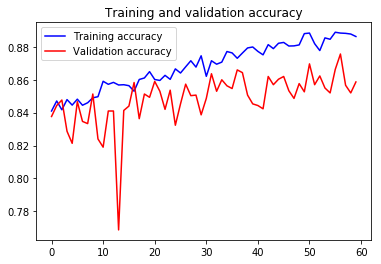

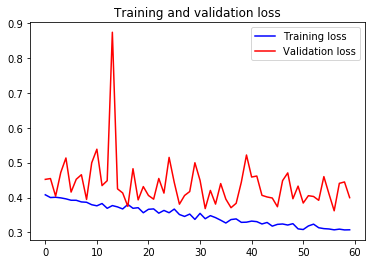

In [47]:
accuracy = modelFilt.history.history['acc']
val_accuracy = modelFilt.history.history['val_acc']
loss = modelFilt.history.history['loss']
val_loss = modelFilt.history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [48]:
modelFilt.evaluate(valid_X, valid_ground, verbose=0)

[0.3619530050754547, 0.8756666666666667]

In [49]:
#testing
test_eval = modelFilt.evaluate(test_three_data, test_three_label_one_hot, verbose=0)
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.34732699076334633
Test accuracy: 0.879666666507721
